<a href="https://colab.research.google.com/github/abdulkhaliq0111/TheSparksFoundationInternship/blob/master/stock_prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install yfinance --upgrade --no-cache-dir

     |████████████████████████████████| 5.5MB 16.8MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22616 sha256=ae24e7b60c0caeacd214dd9199e55b3cc6360f50bceacb83359f38ff53e20224
  Stored in directory: /tmp/pip-ephem-wheel-cache-im3df3nz/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
!pip install pmdarima

     |████████████████████████████████| 1.5MB 15.5MB/s 
     |████████████████████████████████| 2.1MB 47.8MB/s 
     |████████████████████████████████| 9.5MB 52.4MB/s 
  Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
#import libraries 
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import altair as alt  #Altair is a declarative statistical visualization library for Python

import statsmodels.api as sm 

from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.multioutput import RegressorChain
from sklearn.ensemble import RandomForestRegressor

In [ ]:
import yfinance as yf
bse_data = yf.download('^BSESN', start='2015-01-01', end='2020-06-30')
#since our Textual Analysis dataset containing news from Times of India News Headlines is only till 30th June 2020. 
#So we will assume today is 29th June 2020 and tomorrow is 30th June 2020. And we have to predict the stock price ((high+low+close)/3) and closing price of BSE index 
#for tomorrow 30th June 2020.
unseenbse_data = yf.download('^BSESN', start='2020-06-30', end='2020-07-01')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
bse_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1345 entries, 2015-01-02 to 2020-06-29
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1345 non-null   float64
 1   High       1345 non-null   float64
 2   Low        1345 non-null   float64
 3   Close      1345 non-null   float64
 4   Adj Close  1345 non-null   float64
 5   Volume     1345 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 73.6 KB


In [ ]:
bse_data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-06-23,35015.730469,35482.160156,34843.691406,35430.429688,35430.429688,25200
2020-06-24,35679.738281,35706.550781,34794.929688,34868.980469,34868.980469,26600
2020-06-25,34525.390625,35081.609375,34499.781250,34842.101562,34842.101562,24600
2020-06-26,35144.781250,35254.878906,34910.339844,35171.269531,35171.269531,24800
2020-06-29,34926.949219,35032.359375,34662.058594,34961.519531,34961.519531,18300


In [ ]:
bse_data.reset_index(inplace=True)
unseenbse_data.reset_index(inplace=True)
bse_data['Date'] = pd.to_datetime(bse_data['Date'], format = '%Y%m%d')
unseenbse_data['Date'] = pd.to_datetime(unseenbse_data['Date'], format = '%Y%m%d')


In [ ]:
bse_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1345 entries, 0 to 1344
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1345 non-null   datetime64[ns]
 1   Open       1345 non-null   float64       
 2   High       1345 non-null   float64       
 3   Low        1345 non-null   float64       
 4   Close      1345 non-null   float64       
 5   Adj Close  1345 non-null   float64       
 6   Volume     1345 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 73.7 KB


Text(0, 0.5, 'Close')

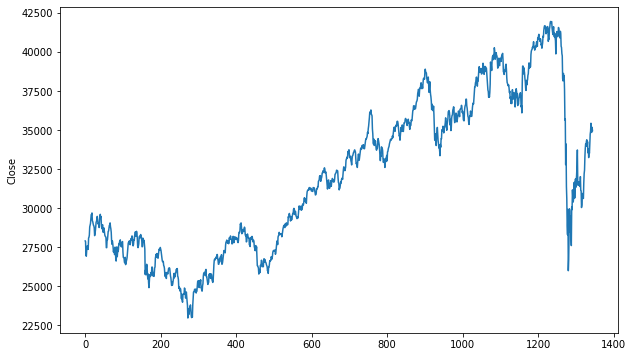

In [ ]:
plt.figure(figsize=(10, 6))
bse_data['Close'].plot()
plt.ylabel('Close')

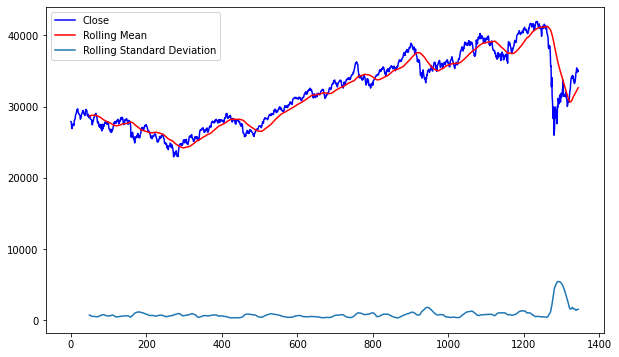

In [ ]:

#Plotting moving average
close = bse_data['Close']
ma = close.rolling(window = 50).mean()
std = close.rolling(window = 50).std()

plt.figure(figsize=(10, 6))
bse_data['Close'].plot(color = 'b', label = 'Close')
ma.plot(color = 'r', label = 'Rolling Mean')
std.plot(label = 'Rolling Standard Deviation')
plt.legend()

Text(0.5, 1.0, 'Returns')

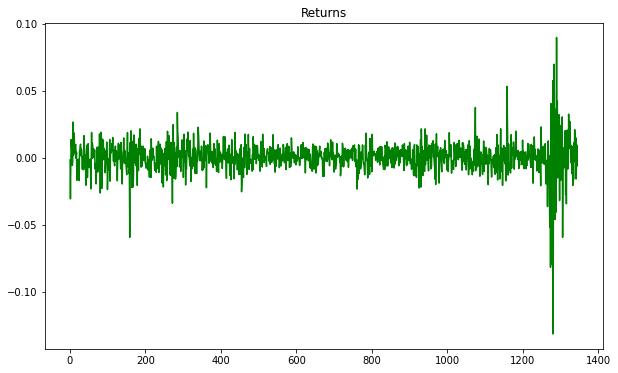

In [ ]:
#Plotting returns
returns = close / close.shift(1) - 1

plt.figure(figsize = (10,6))
returns.plot(label='Return', color = 'g')
plt.title("Returns")

In [ ]:
train = bse_data[:1000]
test = bse_data[1000:]

In [ ]:
train.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-02,27521.279297,27937.470703,27519.259766,27887.900391,27887.900391,7400
1,2015-01-05,27978.429688,28064.490234,27786.849609,27842.320312,27842.320312,9200
2,2015-01-06,27694.230469,27698.929688,26937.060547,26987.460938,26987.460938,14100
3,2015-01-07,26983.429688,27051.599609,26776.119141,26908.820312,26908.820312,12200
4,2015-01-08,27178.769531,27316.410156,27101.939453,27274.710938,27274.710938,8200


In [ ]:

#Stationarity test
def test_stationarity(timeseries):

 #Determing rolling statistics
 rolmean = timeseries.rolling(20).mean()
 rolstd = timeseries.rolling(20).std()

 #Plot rolling statistics:
 plt.figure(figsize = (10,8))
 plt.plot(timeseries, color = 'y', label = 'original')
 plt.plot(rolmean, color = 'r', label = 'rolling mean')
 plt.plot(rolstd, color = 'b', label = 'rolling std')
 plt.xlabel('Date')
 plt.legend()
 plt.title('Rolling Mean and Standard Deviation',  fontsize = 20)
 plt.show(block = False)
 
 print('Results of dickey fuller test')
 result = adfuller(timeseries, autolag = 'AIC')
 labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
 for value,label in zip(result, labels):
   print(label+' : '+str(value) )
 if result[1] <= 0.05:
   print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
 else:
   print("Weak evidence against null hypothesis, time series is non-stationary ")


In [ ]:
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA

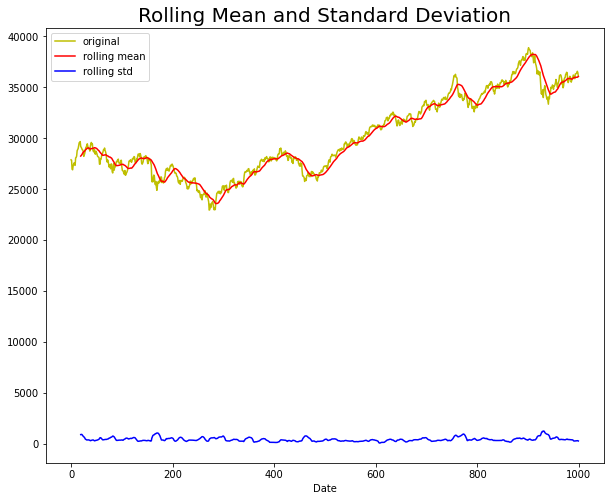

Results of dickey fuller test
ADF Test Statistic : -0.5913676380781216
p-value : 0.8729206808243344
#Lags Used : 1
Number of Observations Used : 998
Weak evidence against null hypothesis, time series is non-stationary 


In [ ]:
test_stationarity(train['Close'])

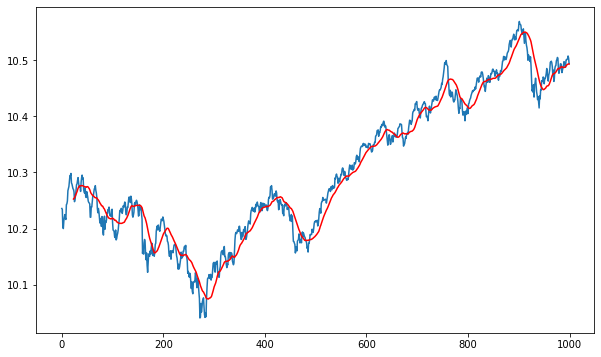

In [ ]:

train_log = np.log(train['Close']) 
test_log = np.log(test['Close'])

mav = train_log.rolling(24).mean() 
plt.figure(figsize = (10,6))
plt.plot(train_log) 
plt.plot(mav, color = 'red')

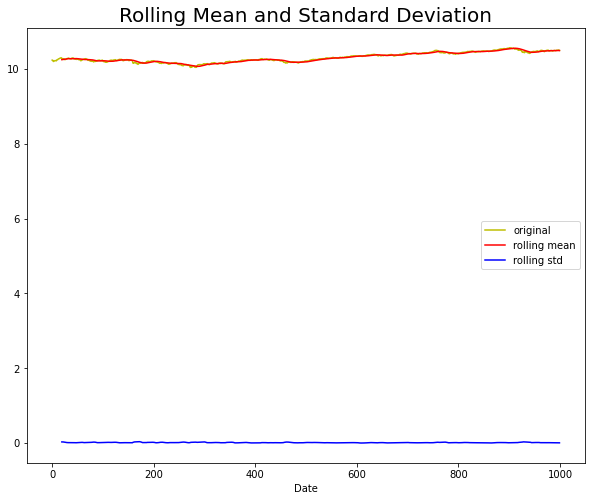

Results of dickey fuller test
ADF Test Statistic : -0.5063496560053631
p-value : 0.8907714361315963
#Lags Used : 6
Number of Observations Used : 993
Weak evidence against null hypothesis, time series is non-stationary 


In [ ]:
train_log.dropna(inplace = True)
test_log.dropna(inplace = True)

test_stationarity(train_log)

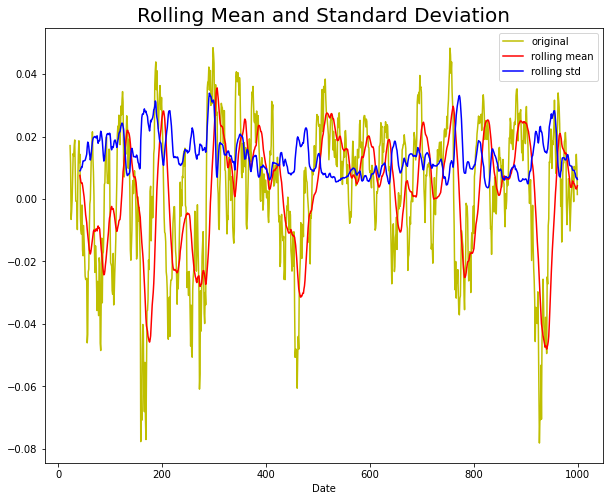

Results of dickey fuller test
ADF Test Statistic : -6.541831419707249
p-value : 9.305308782884714e-09
#Lags Used : 3
Number of Observations Used : 973
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


In [ ]:

train_log_diff = train_log - mav
train_log_diff.dropna(inplace = True)


test_stationarity(train_log_diff)

In [ ]:
#Using auto arima to make predictions using log data
from pmdarima import auto_arima
model = auto_arima(train_log, trace = True, error_action = 'ignore', suppress_warnings = True)
model.fit(train_log)
predictions = model.predict(n_periods = len(test))
predictions = pd.DataFrame(predictions,index = test_log.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-6695.838, Time=1.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6700.141, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6701.586, Time=0.25 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6701.681, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6701.204, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-6700.257, Time=1.40 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-6699.799, Time=0.51 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-6697.783, Time=0.62 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-6702.851, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-6701.366, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-6700.941, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-6702.758, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-6698.902, Time=0.52 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 5.558 seconds


RMSE :  0.10183610203556594


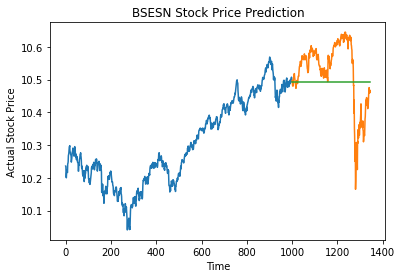

In [ ]:
plt.plot(train_log, label='Train')
plt.plot(test_log, label='Test')
plt.plot(predictions, label='Prediction')
plt.title('BSESN Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')

#Calculating error
rms = np.sqrt(mean_squared_error(test_log,predictions))
print("RMSE : ", rms)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.


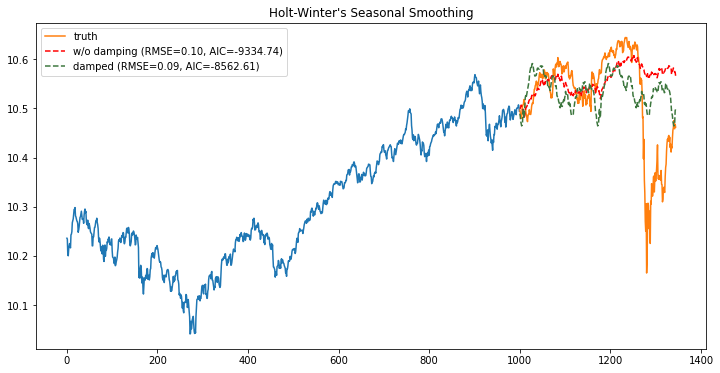

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
X = train_log
Y = test_log
model = ExponentialSmoothing(X, trend="add", seasonal="mul",seasonal_periods=168)
model2 = ExponentialSmoothing(X, trend="add", seasonal="mul", seasonal_periods=168,damped=True)
fit = model.fit()
pred = fit.forecast(345)
fit2 = model2.fit()
pred2 = fit2.forecast(345)

sse1 = np.sqrt(np.mean(np.square(Y - pred)))
sse2 = np.sqrt(np.mean(np.square(Y - pred2)))

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot( X[:1300]);
ax.plot(Y, label='truth');
ax.plot(pred, linestyle='--', color='r', label="w/o damping (RMSE={:0.2f}, AIC={:0.2f})".format(sse1, fit.aic));
ax.plot(pred2, linestyle='--', color='#3c763d', label="damped (RMSE={:0.2f}, AIC={:0.2f})".format(sse2, fit2.aic)); 
ax.legend();
ax.set_title("Holt-Winter's Seasonal Smoothing");

In [ ]:
#RMSE
print('RMSE')
print(np.sqrt(mean_squared_error(Y, pred2)))

RMSE
0.09350177032338167



## Rolling window analysis of time series
Creating 4,16, 24 week moving average of closing price of BSE index

In [ ]:
def stock_weekmovingavg(wks, df):
  dateclose_data = pd.DataFrame({'date': df['Date'], 'close':df['Close']})
  dateclose_data.set_index('date', inplace=True)
  num = wks * 5                                 #calculating the number of days in the week. 5 days because BSE is open for 5 days / week
  dateclose_data['movingavg'] = dateclose_data['close'].rolling(window=num).mean().shift()
  return dateclose_data.dropna()

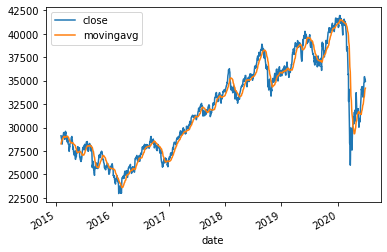

In [ ]:
stock_weekmovingavg(4, bse_data).plot()

In [46]:

altdata_fourweek = stock_weekmovingavg(4, bse_data)
altdata_fourweek.reset_index(inplace=True)
altdata_fourweek.rename(columns={list(altdata_fourweek)[0]:'date'}, inplace=True)

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  Default is None.


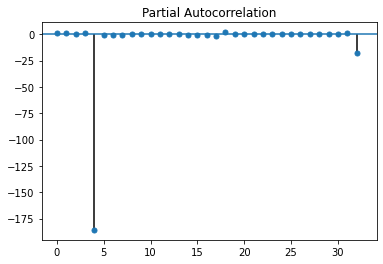

In [47]:

plotfourweek = altdata_fourweek.filter(['date', 'movingavg'], axis=1) #df.copy()
plotfourweek.index = pd.Index(sm.tsa.datetools.dates_from_range('2015', length=len(altdata_fourweek['date']))) 
del plotfourweek['date']
sm.graphics.tsa.plot_pacf(plotfourweek.values.squeeze())
plt.show()

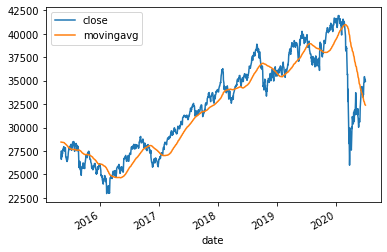

In [ ]:
stock_weekmovingavg(16, bse_data).plot()

In [48]:

altdata_sixteenweek = stock_weekmovingavg(16, bse_data)
altdata_sixteenweek.reset_index(inplace=True)
altdata_sixteenweek.rename(columns={list(altdata_sixteenweek)[0]:'date'}, inplace=True)



/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  Default is None.


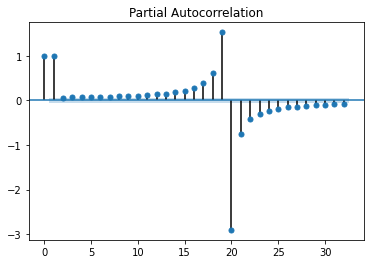

In [49]:
plotsixteenweek = altdata_sixteenweek.filter(['date', 'movingavg'], axis=1) #df.copy()
plotsixteenweek.index = pd.Index(sm.tsa.datetools.dates_from_range('2015', length=len(altdata_sixteenweek['date']))) 
del plotsixteenweek['date']
sm.graphics.tsa.plot_pacf(plotsixteenweek.values.squeeze())
plt.show()


In the partial autocorrelation plot above, we have statistically significant partial autocorrelations at lag values 0, 1, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28. Where 0, 1, 19 represents a perfect positive correlation and 20 represents a perfect negative correlation. While the rest of values are very close to 0 and under the confidence intervals, which are represented as blue shaded regions (which is not vividly seen in the above plot)

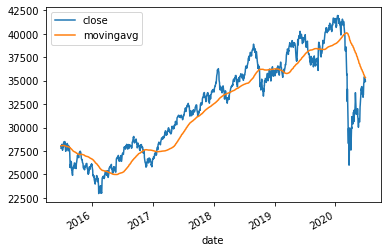

In [ ]:
stock_weekmovingavg(24, bse_data).plot()

In [50]:

altdata_fiftytwoweek = stock_weekmovingavg(24, bse_data)
altdata_fiftytwoweek.reset_index(inplace=True)
altdata_fiftytwoweek.rename(columns={list(altdata_fiftytwoweek)[0]:'date'}, inplace=True)


In [45]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  Default is None.


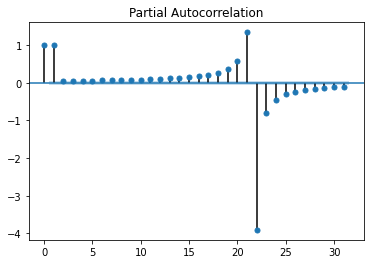

In [51]:

plotfiftytwoweek = altdata_fiftytwoweek.filter(['date', 'movingavg'], axis=1) #df.copy()
plotfiftytwoweek.index = pd.Index(sm.tsa.datetools.dates_from_range('2015', length=len(altdata_fiftytwoweek['date']))) 
del plotfiftytwoweek['date']
sm.graphics.tsa.plot_pacf(plotfiftytwoweek.values.squeeze())
plt.show()


In the partial autocorrelation plot above, we have statistically significant partial autocorrelations at lag values 0, 1 representing a perfect positive correlation. While the rest of values are very close to 0 and under the confidence intervals except 23 and 23, which are represented as blue shaded regions

## Creating a rolling window of size 10 and 50 of the BSE index¶

In [52]:
def rollingwindows(days, df):
  data = df.filter(['Date','Open','High','Low','Close'], axis=1) #df.copy()
  data.set_index('Date', inplace=True)
  rollingwindows_data = data.rolling(window=days).mean().shift()
  return rollingwindows_data.dropna()

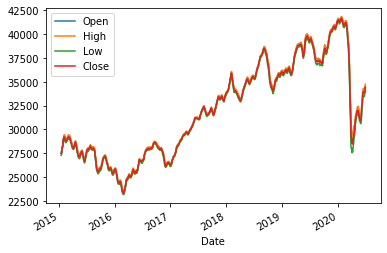

In [53]:
rollingwindows(10, bse_data).plot()

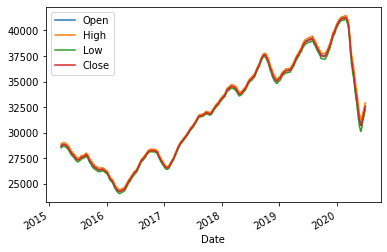

In [54]:
rollingwindows(50, bse_data).plot()

## Creating the dummy time series:
Volume shocks : we will be creating a 0/1 dummy-coded boolean time series for shock, based on whether volume traded is 10% higher/lower than previous day. ( 0/1 dummy-coding is for direction of shock)

In [55]:
def boolean_shock(percent, df, col):
  data = df.filter(['Date', col], axis=1) #df.copy()
  data.set_index('Date', inplace=True)
  data['percentchg'] = (data[col].pct_change()) * 100  #percentage change compare to previous volume using pct_change() function
  data['shock'] = data['percentchg'].apply(lambda x: 1 if x >= percent else 0)
  data.drop(col, axis = 1, inplace = True)
  return data.dropna()

In [56]:
boolean_shock(10, bse_data, 'Volume')

,percentchg,shock
Date,,
2015-01-05,24.324324,1
2015-01-06,53.260870,1
2015-01-07,-13.475177,0
2015-01-08,-32.786885,0
2015-01-09,35.365854,1
...,...,...
2020-06-23,0.398406,0
2020-06-24,5.555556,0
2020-06-25,-7.518797,0


In [57]:

altdata_volpercentchg = boolean_shock(10, bse_data, 'Volume')
altdata_volpercentchg.reset_index(inplace=True)
altdata_volpercentchg.rename(columns={list(altdata_volpercentchg)[0]:'Date'}, inplace=True)



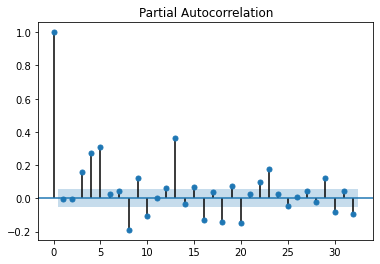

In [58]:
plotvolpercentchg = altdata_volpercentchg.filter(['Date', 'percentchg'], axis=1) #df.copy()
plotvolpercentchg.index = pd.Index(sm.tsa.datetools.dates_from_range('2015', length=len(altdata_volpercentchg['Date']))) 
del plotvolpercentchg['Date']
sm.graphics.tsa.plot_pacf(plotvolpercentchg.values.squeeze())
plt.show()

In the partial autocorrelation plot above, we have statistically significant partial autocorrelations at lag values 0, 3, 4, 5, 8, 9. 10, 12, 13, 15, 16, 18, 19, 20, 22, 23, 29, 30, 32. And lag value 0 represents a perfect positive correlation. While the rest of values are very close to 0 and under the confidence intervals, which are represented as blue shaded regions

In [59]:
boolean_shock(2, bse_data, 'Close')

,percentchg,shock
Date,,
2015-01-05,-0.163440,0
2015-01-06,-3.070360,0
2015-01-07,-0.291397,0
2015-01-08,1.359742,0
2015-01-09,0.673407,0
...,...,...
2020-06-23,1.486937,0
2020-06-24,-1.584653,0
2020-06-25,-0.077085,0


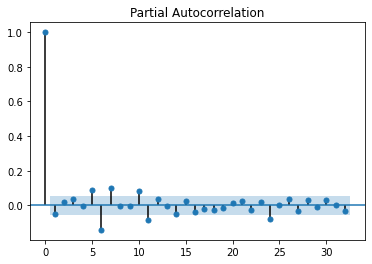

In [60]:

altdata_closepercentchg2 = boolean_shock(2, bse_data, 'Close')
altdata_closepercentchg2.reset_index(inplace=True)
altdata_closepercentchg2.rename(columns={list(altdata_closepercentchg2)[0]:'Date'}, inplace=True)
plotclosepercentchg2 = altdata_closepercentchg2.filter(['Date', 'percentchg'], axis=1) #df.copy()
plotclosepercentchg2.index = pd.Index(sm.tsa.datetools.dates_from_range('2015', length=len(altdata_closepercentchg2['Date']))) 
del plotclosepercentchg2['Date']
sm.graphics.tsa.plot_pacf(plotclosepercentchg2.values.squeeze())
plt.show()

In the partial autocorrelation plot above, we have statistically significant partial autocorrelations at lag values 0, 5, 6, 7, 10, 11, 24. And lag value 0 represents a perfect positive correlation. While the rest of values are very close to 0 and under the confidence intervals, which are represented as blue shaded regions

In [61]:
boolean_shock(10, bse_data, 'Close')

,percentchg,shock
Date,,
2015-01-05,-0.163440,0
2015-01-06,-3.070360,0
2015-01-07,-0.291397,0
2015-01-08,1.359742,0
2015-01-09,0.673407,0
...,...,...
2020-06-23,1.486937,0
2020-06-24,-1.584653,0
2020-06-25,-0.077085,0


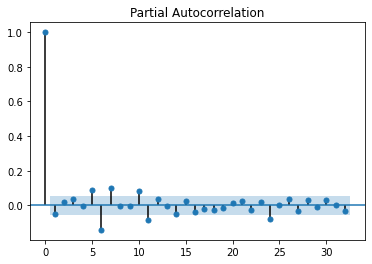

In [62]:

altdata_closepercentchg10 = boolean_shock(10, bse_data, 'Close')
altdata_closepercentchg10.reset_index(inplace=True)
altdata_closepercentchg10.rename(columns={list(altdata_closepercentchg10)[0]:'Date'}, inplace=True)
plotclosepercentchg10 = altdata_closepercentchg10.filter(['Date', 'percentchg'], axis=1) #df.copy()
plotclosepercentchg10.index = pd.Index(sm.tsa.datetools.dates_from_range('2015', length=len(altdata_closepercentchg2['Date']))) 
del plotclosepercentchg10['Date']
sm.graphics.tsa.plot_pacf(plotclosepercentchg2.values.squeeze())
plt.show()

In the partial autocorrelation plot above, we have statistically significant partial autocorrelations at lag values 0, 5, 6, 7, 10, 11, 24. And lag value 0 represents a perfect positive correlation. While the rest of values are very close to 0 and under the confidence intervals, which are represented as blue shaded regions


## Pricing shock without volume shock



In [63]:
def priceboolean_shock(percent, df):
  df['Date'] = pd.to_datetime(df['Date'])
  data = df.filter(['Date', 'High', 'Low','Close'], axis=1) #df.copy()
  data.set_index('Date', inplace=True)
  data['priceavg'] = (data['High'] + data['Low'] + data['Close']) / 3
  data['shock'] = (data['priceavg'].pct_change()) * 100
  data['shock'] = data['shock'].apply(lambda x: 1 if x >= percent else 0)
  data.drop(['High', 'Low', 'Close'], axis = 1, inplace = True)
  return data


In [64]:
priceboolean_shock(10, bse_data)

,priceavg,shock
Date,,
2015-01-02,27781.543620,0
2015-01-05,27897.886719,0
2015-01-06,27207.817057,0
2015-01-07,26912.179688,0
2015-01-08,27231.020182,0
...,...,...
2020-06-23,35252.093750,0
2020-06-24,35123.486979,0
2020-06-25,34807.830729,0


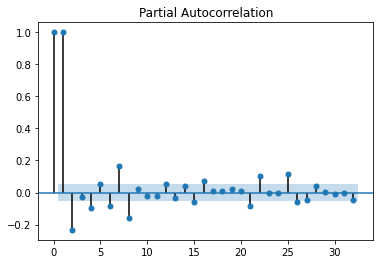

In [65]:

altdata_pricepercentchg = priceboolean_shock(10, bse_data)
altdata_pricepercentchg.reset_index(inplace=True)
altdata_pricepercentchg.rename(columns={list(altdata_pricepercentchg)[0]:'date'}, inplace=True)


plotpricepercentchg = altdata_pricepercentchg.filter(['date', 'priceavg'], axis=1) #df.copy()
plotpricepercentchg.index = pd.Index(sm.tsa.datetools.dates_from_range('2015', length=len(altdata_pricepercentchg['date']))) 
del plotpricepercentchg['date']
sm.graphics.tsa.plot_pacf(plotpricepercentchg.values.squeeze())
plt.show()


In the partial autocorrelation plot above, we have statistically significant partial autocorrelations at lag values 0, 1, 2, 4, 6, 7, 8, 15, 16, 21, 22, 25, 26. And lag values 0, 1 represents a perfect positive correlation. While the rest of values are very close to 0 and under the confidence intervals, which are represented as blue shaded regions

## Creating the reverse dummy time series:
Price shocks : we will be creating a 0/1 dummy-coded boolean time series for shock, based on whether closing price at T vs T+1 has a difference > 2%. ( 0/1 dummy-coding is for direction of shock). This will be reverse of pct_change()

In [66]:

def reverseboolean_shock(percent, df, col):
  data = df.filter(['Date', col], axis=1) #df.copy()
  data.set_index('Date', inplace=True)
  data = data.reindex(index=data.index[::-1])
  data['percentchg'] = (data[col].pct_change()) * 100
  data['shock'] = data['percentchg'].apply(lambda x: 1 if x > percent else 0)
  data.drop(col, axis = 1, inplace = True)
  data = data.reindex(index=data.index[::-1])
  return data.dropna()

In [67]:
reverseboolean_shock(2, bse_data, 'Close')

,percentchg,shock
Date,,
2015-01-02,0.163708,0
2015-01-05,3.167617,1
2015-01-06,0.292249,0
2015-01-07,-1.341501,0
2015-01-08,-0.668903,0
...,...,...
2020-06-22,-1.465151,0
2020-06-23,1.610168,0
2020-06-24,0.077145,0


In [68]:
reverseboolean_shock(5, bse_data, 'Close')

,percentchg,shock
Date,,
2015-01-02,0.163708,0
2015-01-05,3.167617,0
2015-01-06,0.292249,0
2015-01-07,-1.341501,0
2015-01-08,-0.668903,0
...,...,...
2020-06-22,-1.465151,0
2020-06-23,1.610168,0
2020-06-24,0.077145,0



Pricing shock without volume shock : Now we will be creating a time series for pricing shock without volume shock based on whether price at T vs T+1 has a difference > 2%. ( 0/1 dummy-coding is for direction of shock). This will be reverse of pct_change()

In [69]:
def pricereverseboolean_shock(percent, df):
  data = df.filter(['Date', 'High', 'Low','Close'], axis=1) #df.copy()
  data.set_index('Date', inplace=True)
  data = data.reindex(index=data.index[::-1])
  data['reversepriceavg'] = (data['High'] + data['Low'] + data['Close']) / 3
  data['shock'] = (data['reversepriceavg'].pct_change()) * 100
  data['shock'] = data['shock'].apply(lambda x: 1 if x >= percent else 0)
  data.drop(['High', 'Low', 'Close'], axis = 1, inplace = True)
  data = data.reindex(index=data.index[::-1])
  return data.dropna()

In [70]:
pricereverseboolean_shock(2, bse_data)

,reversepriceavg,shock
Date,,
2015-01-02,27781.543620,0
2015-01-05,27897.886719,1
2015-01-06,27207.817057,0
2015-01-07,26912.179688,0
2015-01-08,27231.020182,0
...,...,...
2020-06-23,35252.093750,0
2020-06-24,35123.486979,0
2020-06-25,34807.830729,0


## Textual Analysis of news from Times of India News Headlines

In [71]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [73]:

news = pd.read_csv("/content/gdrive/MyDrive/india-news-headlines.csv")


In [74]:

#getting the overview of all the columns in the news dataset
news.columns

Index(['publish_date', 'headline_category', 'headline_text'], dtype='object')

In [75]:

#converting publish_date column to 
news['publish_date'] = pd.to_datetime(news['publish_date'], format = '%Y%m%d')

In [76]:
news.head()

,publish_date,headline_category,headline_text
0,2001-01-01,sports.wwe,win over cena satisfying but defeating underta...
1,2001-01-02,unknown,Status quo will not be disturbed at Ayodhya; s...
2,2001-01-02,unknown,Fissures in Hurriyat over Pak visit
3,2001-01-02,unknown,America's unwanted heading for India?
4,2001-01-02,unknown,For bigwigs; it is destination Goa


In [77]:

#checking all the values count (unique values total count)
news['headline_category'].value_counts()

india                      285619
unknown                    207732
city.mumbai                132649
city.delhi                 124658
business.india-business    115246
                            ...  
ballot-talk                     7
delhi-ncr                       7
did-you-know                    6
sports.headline6                3
party-manifestos                2
Name: headline_category, Length: 1016, dtype: int64

In [78]:

#total unique values count
news['headline_category'].value_counts().count()

1016

In [79]:

#checking all the values count (unique values total count)
news['headline_text'].value_counts()

Sunny Leone HOT photos                                                  98
Watch top news in one-minute                                            90
Official Site                                                           89
Football: Italian Serie A table                                         88
Football: Spanish La Liga table                                         86
                                                                        ..
This road leaves people breathless                                       1
When Shah Rukh Khan was told that he was ugly and not the hero-type!     1
Dhadrianwale cancels discourse in Amritsar                               1
Asif Ali in Mannar Mathai Speaking's sequel?                             1
Gene-targeting drugs can fight viruses better than vaccines              1
Name: headline_text, Length: 3082589, dtype: int64

In [80]:
#total unique values count
news['headline_text'].value_counts().count()

3082589

In [81]:
#rough checking by marking all duplicates as True. Default is first which marks duplicates as True except for the first occurrence.
news.duplicated(keep=False).sum()

41638

In [82]:

#sorting the dataset to delete the duplicates, to make duplicates come together one after another. The sorted dataset index values are also changed
cols = list(news.columns)
news.sort_values(by=cols, inplace=True, ignore_index=True)


In [83]:
news[news.duplicated(keep=False)]

,publish_date,headline_category,headline_text
4,2001-01-02,unknown,America's unwanted heading for India?
5,2001-01-02,unknown,America's unwanted heading for India?
6,2001-01-02,unknown,America's unwanted heading for India?
7,2001-01-02,unknown,America's unwanted heading for India?
10,2001-01-02,unknown,BBC's reality TV will focus on AIIMS
...,...,...,...
3296358,2020-06-29,city.kochi,Face-detection cams set to nab violators in Th...
3296538,2020-06-29,city.ranchi,To boost sales; liquor sellers in Jharkhand ur...
3296539,2020-06-29,city.ranchi,To boost sales; liquor sellers in Jharkhand ur...
3297012,2020-06-30,city.patna,Groom dead; 90 guests test Covid positive in P...


In [84]:

#dropping the duplicates only keeping the last value (ordinally last row from sorted) of each duplicates
news.drop_duplicates(keep='last', inplace=True, ignore_index=True)

In [85]:
lst = news['publish_date'].value_counts().index.tolist()

In [86]:
#concatenating all the headline_text column values of same date in publish_date column
new = []
for x in lst:
  df = news.loc[news['publish_date'] == x]
  headlinetext = ''
  publishdate = str(x)
  headlinetext = df['headline_text'].iloc[0]
  for i in range(1 , len(df)):
    headlinetext = headlinetext + '. '+ df['headline_text'].iloc[i]  
  new.append(headlinetext)

In [87]:

#creating a new dataset
newsdf = pd.DataFrame({'publish_date': lst, 'headline_text' : new})

In [88]:

newsdf

,publish_date,headline_text
0,2018-07-31,Harley Davidson plans smaller bike with eye on...
1,2018-12-31,Court extends detention for Nissan ex-chair Gh...
2,2018-12-30,expect to nearly treble sales in india in 2019...
3,2014-12-31,Exclusive! BMW i8 India launch in February 201...
4,2017-12-31,53k casual jobs lost in Jan-Mar;overall employ...
...,...,...
7075,2001-06-05,Darkness Triumphs
7076,2001-03-17,Crouching Tiger; Hidden Dragon
7077,2001-04-01,Indians attacked by 'monkey man'
7078,2001-03-13,Expose rocks nation


In [89]:
#sorting the dataset based on dates
newsdf.sort_values(by='publish_date', inplace=True, ignore_index=True)

In [90]:
newsdf.head()

,publish_date,headline_text
0,2001-01-01,win over cena satisfying but defeating underta...
1,2001-01-02,Raju Chacha. A noisy effort to spruce up Comme...
2,2001-01-03,'Devdas': Jinxed?. 10-year-old girl missing. 3...
3,2001-01-04,Car dealers caught in Bihar sales tax ruling. ...
4,2001-01-05,Nepal won't allow anti-India activities: Envoy...


In [91]:
from textblob import TextBlob
polarity = []
subjectivity = []
for idx, row in newsdf.iterrows():
  polarity.append(TextBlob(row['headline_text']).sentiment[0])
  subjectivity.append(TextBlob(row['headline_text']).sentiment[1])

In [92]:

newsdf['polarity'] = polarity
newsdf['subjectivity'] = subjectivity

In [93]:


#renameing the publish_date to date so it will help us during joining this dataset with bse_data dataset
newsdf.rename(columns={'publish_date': 'Date'}, inplace = True)

In [94]:

#selecting required columns
newsdf = newsdf.filter(['Date', 'polarity', 'subjectivity'], axis=1)

In [95]:
newsdf.head()

,Date,polarity,subjectivity
0,2001-01-01,0.433333,0.633333
1,2001-01-02,0.193519,0.293056
2,2001-01-03,0.088462,0.407692
3,2001-01-04,0.091426,0.481895
4,2001-01-05,0.257415,0.465542


In [96]:
bse_data = pd.merge(bse_data, newsdf, how='left', on=['Date'])

In [97]:
bse_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,polarity,subjectivity
0,2015-01-02,27521.279297,27937.470703,27519.259766,27887.900391,27887.900391,7400,0.055586,0.455251
1,2015-01-05,27978.429688,28064.490234,27786.849609,27842.320312,27842.320312,9200,0.100081,0.433132
2,2015-01-06,27694.230469,27698.929688,26937.060547,26987.460938,26987.460938,14100,0.055802,0.386579
3,2015-01-07,26983.429688,27051.599609,26776.119141,26908.820312,26908.820312,12200,0.034707,0.386916
4,2015-01-08,27178.769531,27316.410156,27101.939453,27274.710938,27274.710938,8200,0.060173,0.408416



## Preparing the dataset for machine learning

In [98]:
#adding new row for 30th June 2020 (price to be predicted of this day) to main dataset to get average values of all the columns for this day
#taking average because we don't know the values of all the columns for tomorrow so to predict we need average for independent variable.
#We will separate this row later from this main dataset so we can use this as prediction of unseen data for tomorrow. 
#And then tally it with actual data from unseenbse_data dataset which we have downloaded too for 30th June 2020 actual values
bse_data.loc[len(bse_data)] = ['2020-06-30', bse_data['Open'].mean(), bse_data['High'].mean(), bse_data['Low'].mean(),
                       bse_data['Close'].mean(), bse_data['Adj Close'].mean(), bse_data['Volume'].median(), newsdf['polarity'].mean(), newsdf['subjectivity'].mean() ]

In [99]:
bse_data['date'] = pd.to_datetime(bse_data['Date'], format="%Y-%m-%d")

In [100]:
bse_data["month"] = bse_data['date'].dt.month
bse_data["day"] = bse_data['date'].dt.day
bse_data["dayofweek"] = bse_data['date'].dt.dayofweek
bse_data["week"] = bse_data['date'].dt.week
bse_data['movingavg4weeks'] = round(bse_data['Close'].rolling(window=(4*5), min_periods = 1).mean().shift(),2)
bse_data['movingavg16weeks'] = round(bse_data['Close'].rolling(window=(16*5), min_periods = 1).mean().shift(),2) #add 12 weeks to 4 weeks 
bse_data['movingavg28weeks'] = round(bse_data['Close'].rolling(window=(28*5), min_periods = 1).mean().shift(),2) #add 12 weeks to 16 weeks
bse_data['movingavg40weeks'] = round(bse_data['Close'].rolling(window=(40*5), min_periods = 1).mean().shift(),2) #add 12 weeks to 28 weeks
bse_data['movingavg52weeks'] = round(bse_data['Close'].rolling(window=(52*5), min_periods = 1).mean().shift(),2)  #add 12 weeks to 40 weeks
bse_data['window10days'] = round(bse_data['Close'].rolling(window = 10, min_periods = 1).mean().shift(),2)  
bse_data['window50days'] = round(bse_data['Close'].rolling(window = 50, min_periods = 1).mean().shift(),2)
bse_data['volumeshock'] = round(boolean_shock(10, bse_data, 'Volume').reset_index()['shock'], 2)
bse_data['closeshock2'] = round(reverseboolean_shock(2, bse_data, 'Close').reset_index()['shock'], 2)
bse_data['closeshock5'] = round(reverseboolean_shock(5, bse_data, 'Close').reset_index()['shock'],2)
bse_data['closeshock10'] = round(reverseboolean_shock(10, bse_data, 'Close').reset_index()['shock'], 2)
bse_data['priceshock'] = round(priceboolean_shock(10, bse_data).reset_index()['shock'], 2)
bse_data['reversebooleanshock2'] = round(reverseboolean_shock(2, bse_data, 'Close').reset_index()['shock'], 2)
bse_data['reversebooleanshock5'] = round(reverseboolean_shock(5, bse_data, 'Close').reset_index()['shock'], 2)
bse_data['pricereverseshock2'] = round(pricereverseboolean_shock(2, bse_data).reset_index()['shock'], 2)
bse_data['polarity'] = round(bse_data['polarity'] , 2)
bse_data['subjectivity'] = round(bse_data['subjectivity'] , 2)
bse_data['price'] = round((bse_data['High'] + bse_data['Low'] + bse_data['Close']) / 3 , 2)
bse_data['close'] = round(bse_data['Close'] , 2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  after removing the cwd from sys.path.


In [101]:

#selecting specific columns
bse_data = bse_data.filter(['month', 'day', 'dayofweek', 'week',
       'movingavg4weeks', 'movingavg16weeks', 'movingavg28weeks',
       'movingavg40weeks', 'movingavg52weeks', 'window10days', 'window50days',
       'volumeshock', 'closeshock2', 'closeshock5', 'closeshock10',
       'priceshock', 'reversebooleanshock2', 'reversebooleanshock5',
       'pricereverseshock2', 'polarity', 'subjectivity', 'price', 'close'], axis=1)

In [129]:

#fillinf the null columns
bse_data.fillna(method = 'bfill', inplace = True)

#fillinf the null columns
bse_data.fillna(method = 'ffill', inplace = True)

In [130]:
bse_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1346 entries, 0 to 1345
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   month                 1346 non-null   int64  
 1   day                   1346 non-null   int64  
 2   dayofweek             1346 non-null   int64  
 3   week                  1346 non-null   int64  
 4   movingavg4weeks       1346 non-null   float64
 5   movingavg16weeks      1346 non-null   float64
 6   movingavg28weeks      1346 non-null   float64
 7   movingavg40weeks      1346 non-null   float64
 8   movingavg52weeks      1346 non-null   float64
 9   window10days          1346 non-null   float64
 10  window50days          1346 non-null   float64
 11  volumeshock           1346 non-null   float64
 12  closeshock2           1346 non-null   float64
 13  closeshock5           1346 non-null   float64
 14  closeshock10          1346 non-null   float64
 15  priceshock           

In [131]:

#separating the predicted date row from main dataset after getting all the calculated average values
main_bsedata = bse_data.iloc[:1345,:].reset_index()  
newtestunseen_bsedata = bse_data.iloc[1345:,:].reset_index()

In [132]:
X = main_bsedata.drop(['price','close'], axis = 1)
y = main_bsedata[['price','close']]

In [133]:

Xnewtestunseen = newtestunseen_bsedata.drop(['price','close'], axis = 1)
ynewtestunseen_ans = newtestunseen_bsedata[['price','close']]

In [134]:

split = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
for train_index, test_index in split.split(X, y):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [135]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1076, 22), (1076, 2), (269, 22), (269, 2))

There are two ways to predict values of two columns one is

Direct Multioutput Regression:

It involves seperating each target variable as independent regression problem, that is here it presumably assumes the outputs to be independent of each other.

Chained Multioutput Regression:

It involves creating a series of regression models from single output regression model, that is the first model in the sequence uses the input and predicts one output then the second model uses the input and the output from the first model to make a prediction and it goes on depending on the number of target variables.

In this case Chained Multioutput Regression will be more appropriate option as the stock price ((high+low+close)/3) and closing price are interdependent.

In [136]:

rfg = RandomForestRegressor(random_state = 42, n_estimators = 500, criterion='mse', max_depth = 30, min_samples_leaf=2, min_samples_split=5, n_jobs=1)

In [137]:
chainedmodel = RegressorChain(rfg)
chainedmodel.fit(X_train, y_train)

RegressorChain(base_estimator=RandomForestRegressor(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    criterion='mse',
                                                    max_depth=30,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=2,
                                                    min_samples_split=5,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators=500, n_jobs=1,
                                                   

In [138]:

pred = chainedmodel.predict(X_test)
roundpred = []
for x in range(len(pred)):
  roundpred.append([round(pred[x][0], 2),round(pred[x][1], 2) ])

In [139]:

r2_score(y_test, roundpred)

0.9946099700957691

In [140]:

#evaluating the performance of the model
#MAE
print('MAE')
print(mean_absolute_error(y_test, roundpred), end='\n')
#MSE
print('MSE')
print(mean_squared_error(y_test, roundpred), end='\n')
#RMSE
print('RMSE')
print(np.sqrt(mean_squared_error(y_test, roundpred)))

MAE
256.589498141264
MSE
130635.34228159863
RMSE
361.43511489837095


In [141]:
import xgboost 
import lightgbm


In [142]:
from sklearn.multioutput import MultiOutputRegressor
multioutputregressor = MultiOutputRegressor(xgboost.XGBRegressor(objective='reg:linear')).fit(X_train, y_train)

[08:16:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:16:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [143]:
print (np.mean((multioutputregressor.predict(X) - y)**2, axis=0))

price    115340.540692
close    132631.626705
dtype: float64


In [144]:
xgbpred = multioutputregressor.predict(X_test)
roundpred = []
for x in range(len(pred)):
  roundpred.append([round(xgbpred[x][0], 2),round(xgbpred[x][1], 2) ])

In [145]:

r2_score(y_test, roundpred)

0.9927603577866613

In [146]:

#evaluating the performance of the model
#MAE
print('MAE')
print(mean_absolute_error(y_test, roundpred), end='\n')
#MSE
print('MSE')
print(mean_squared_error(y_test, roundpred), end='\n')
#RMSE
print('RMSE')
print(np.sqrt(mean_squared_error(y_test, roundpred)))

MAE
326.5716445457714
MSE
175435.59299953983
RMSE
418.8503229072885


In [147]:
Xnewtestunseen.shape

(1, 22)

In [148]:

pred_newtestunseen = chainedmodel.predict(Xnewtestunseen)

In [149]:
[(round(pred_newtestunseen[0][0], 2)),(round(pred_newtestunseen[0][1], 2))]

[35099.15, 35073.89]

In [150]:

ynewtestunseen_ans  #used average of high, low, close, volume to calculate price ((high+low+close)/3) and close value

,price,close
0,31990.55,31984.24


In [154]:

#before moving forward let us calculate first the actual price
unseenbsedata_price = round((unseenbse_data['High'] + unseenbse_data['Low'] + unseenbse_data['Close'])/ 3, 2)
unseenbsedata_price  #actual price

0    34987.5
dtype: float64

In [155]:

[unseenbsedata_price[0] , round(unseenbse_data['Close'],2)[0]] #actual price ((high+low+close)/3) calculated earlier and the closing price

[34987.5, 34915.8]


The model predicted for 30th June 2020 the price ((high+low+close)/3) i.e the average of high, low, close of BSE index to be 35020.02 and closing price to be 34955.46

And the actual price ((high+low+close)/3) i.e the average of high, low, close of BSE index on day 30th June 2020 was 34987.5, and closing price was 34915.8

So as seen above our model has done a very good prediction